# Classification

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Features engineering

-> toutes les données de users
-> mois
-> toutes les triplets d'actions possibles
-> time_elapsed
-> 

In [65]:
# Import data
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

# Add labels DF/NDF
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)

# Retain users that have a session & add information about their session
sessions_naless = sessions.fillna('_')
sessions['action_name'] = sessions_naless['action'] + '-' + sessions_naless['action_type'] + '-' + sessions_naless['action_detail']
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='inner', on='id')

# Make dataset balanced by keeping the smae number users in each classes
n = min(users[users['destination_found'] == 'NDF'].shape[0], users[users['destination_found'] == 'DF'].shape[0])
users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)
users = users.sort_values('id')

In [66]:
print("users.head : ", users.shape)
users.tail()

users.head :  (57548, 19)


,id,actions,hours_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
53866,zzq90ckj2z,"[_-message_post-message_post, pending-booking_...",167.0,2014-04-17,20140417150926,2014-04-18,-unknown-,105.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,US,DF
12434,zzv8sgicbk,"[create-submit-create_user, personalize-data-w...",129.0,2014-02-25,20140225060628,2014-02-25,MALE,27.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US,DF
5243,zzvr84im58,"[authenticate-submit-login, header_userpic-dat...",21.0,2014-03-15,20140315022507,2014-03-17,MALE,32.0,facebook,12,en,api,other,untracked,iOS,iPhone,Mobile Safari,US,DF
36055,zzy7t0y9cm,"[personalize-data-wishlist_content_update, hea...",20.0,2014-03-27,20140327185345,2014-03-29,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,US,DF
5839,zzzlylp57e,"[similar_listings-data-similar_listings, show-...",120.0,2014-06-11,20140611074639,2014-06-24,-unknown-,NaN,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,FR,DF


In [67]:
# Converting date string into datetime object
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [68]:
def process_age(age):
    if age > 1000:
        return 2015 - age
    elif age == 105:
        return -2
    elif age < 100:
        return age
    else: 
        return -1

# Bucketize age variable
users['age'] = users.apply(lambda r: process_age(r['age']), axis=1)
users['age_group'] = sum([(users['age'] < 0).astype(int),
    (users['age'] < 18).astype(int),
    (users['age'] < 25).astype(int),
    (users['age'] < 30).astype(int),
    (users['age'] < 35).astype(int),
    (users['age'] < 40).astype(int),
    (users['age'] < 60).astype(int),
    (users['age'] < 100).astype(int)])

In [69]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
    
# Bucketize signup_flow
users['signup_flow_group'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)

In [70]:
# Bucketize language
users['language_group'] = (users['language'] == 'en').astype(int)

In [71]:
# Only retains browser which have a large enough set of users
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browser_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

In [72]:
# Fill Nan in first_affiliate_tracked
users['first_affiliate_tracked'] = users['first_affiliate_tracked'].fillna('-unknown-')

In [73]:
relevent_action_names = ['requested-submit-post_checkout_action',
 'requested-view-p5',
 'pending-booking_request-pending',
 'agree_terms_check--unknown---unknown-',
 'at_checkpoint-booking_request-at_checkpoint',
 'ajax_photo_widget_form_iframe--unknown---unknown-',
 'complete_status--unknown---unknown-',
 'complete_redirect--unknown---unknown-',
 'travel_plans_current-view-your_trips',
 'populate_from_facebook--unknown---unknown-',
 'social_connections-data-user_social_connections',
 'collections-view-user_wishlists',
 'campaigns-_-_',
 'update-submit-update_user',
 'notifications-submit-notifications',
 'search-click-view_search_results',
 'create-submit-signup',
 'update-submit-update_listing_description',
 'manage_listing-view-manage_listing',
 'set_user-submit-create_listing']


# Encode actions
one_hot_encoded_actions = pd.get_dummies(sessions[sessions['action_name'].isin(relevent_action_names)][['user_id', 'action_name']], columns=['action_name'])

# Generate functions for aggretation
columns = one_hot_encoded_actions.columns.values.tolist()
columns.remove('user_id')
agg_funcs = {col_name: sum for col_name in columns}

# Aggretate actions by users
actions_matrix = one_hot_encoded_actions.groupby('user_id').agg(agg_funcs)

# Selecting the most relevent columns
cols = ['action_name_' + name for name in relevent_action_names]
m = actions_matrix[cols].div(actions_matrix[cols].std(axis=1), axis=0).fillna(0)
m.head()

,action_name_requested-submit-post_checkout_action,action_name_requested-view-p5,action_name_pending-booking_request-pending,action_name_agree_terms_check--unknown---unknown-,action_name_at_checkpoint-booking_request-at_checkpoint,action_name_ajax_photo_widget_form_iframe--unknown---unknown-,action_name_complete_status--unknown---unknown-,action_name_complete_redirect--unknown---unknown-,action_name_travel_plans_current-view-your_trips,action_name_populate_from_facebook--unknown---unknown-,...,action_name_dashboard-view-dashboard,action_name_index-view-view_search_results,action_name_confirm_email-click-confirm_email_link,action_name_create-submit-create_user,action_name_similar_listings-data-similar_listings,action_name_ajax_refresh_subtotal-click-change_trip_characteristics,action_name_personalize-data-wishlist_content_update,action_name_show-_-_,action_name_show-view-p3,action_name_header_userpic-data-header_userpic
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0.0,2.757215,0.551443,0.0,0.000000,0.0,0.0,0.0,1.102886,0.0,...,2.205772,2.205772,0.551443,0.000000,1.654329,1.102886,2.205772,1.654329,3.308659,1.102886
0010k6l0om,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.622899,0.622899,0.000000,0.000000,0.000000,2.491596,2.491596,2.180146,4.048843,0.311449
001wyh0pz8,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166749,0.166749,0.000000
0028jgx1x1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.438287,0.000000,0.000000,0.000000,0.000000,3.944582,0.000000
002qnbzfs5,0.0,0.000000,0.000000,0.0,0.038246,0.0,0.0,0.0,0.000000,0.0,...,0.076492,0.000000,0.038246,0.000000,0.000000,0.000000,0.000000,0.267723,0.956155,0.076492


In [74]:
users = users.merge(m.round(0).reset_index().rename({'user_id':'id'}, axis=1), how='left', on='id').fillna(0)

In [75]:
# Selecting features
features = ['month_first_active', 'year_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group', 'affiliate_channel', 'affiliate_provider', 
           'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser_processed', 'language_group']

features += ['action_name_' + name for name in relevent_action_names]

data = users[features].copy()

X = pd.get_dummies(data)
y = users['destination_found'].values
# y = users['country_destination'].values

In [76]:
data.shape

(57548, 43)

## Training model

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, max_depth=16)
res = cross_val_score(model, X=X, y=y)
print(f"Mean score : {np.mean(res)}")
print(f"Std score : {np.std(res)}")

Mean score : 0.7562556285984472
Std score : 0.0016279269894972925


[[0.65897494 0.34102506]
 [0.17077891 0.82922109]]


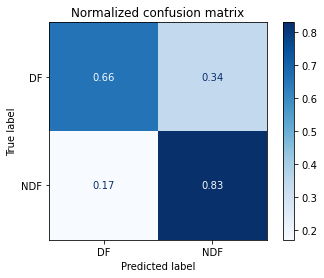

In [78]:
from sklearn.metrics import plot_confusion_matrix
n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X[n:], y[n:], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)